In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import astropy.constants as aconst
from pycbc.filter import sigmasq
from pycbc import waveform
from calcwf import chirp2total, gen_wf, ceiltwo, gen_psd, shifted_e, shifted_e_approx
from scipy.optimize import minimize
import os
import time
import pickle

In [2]:
e_params = [0.05, 0.1, 0.2]
chirp_params = [10, 24, 50]
e_vals_10 = [np.linspace(0, 0.2, 31), np.linspace(0, 0.2, 31), np.linspace(0, 0.3, 31)]
chirp_vals_10 = [np.linspace(9.9, 10.1, 31), np.linspace(23, 25, 31), np.linspace(44, 56, 31)]

# Exact effective chirp mass

To work out more exact effective chirp mass, we need to follow original approach in Favata et al. (https://arxiv.org/pdf/2108.05861.pdf), but retain $e_t$ instead of approximating it to lowest order. The effective chirp mass will then appear in the second derivative of the phae, which we must calculate.

$$
\Psi_\textrm{ecc, 0PN} \propto \frac{1}{\mathcal{M}^{5/3}f^{5/3}}\left[1-\frac{2355}{1462}e_t^2\right]
$$

$$
\frac{d\Psi}{df} \propto - \frac{5}{3\mathcal{M}^{5/3}f^{8/3}}\left[1-\frac{2355}{1462}e_t^2\right] - \frac{1}{\mathcal{M}^{5/3}f^{5/3}} \left[\frac{2355}{1462}\frac{de_t^2}{df}\right]
$$

$$
\frac{d^2\Psi}{df^2} \propto \frac{40}{9\mathcal{M}^{5/3}f^{11/3}}\left[1-\frac{2355}{1462}e_t^2\right] + \frac{10}{3\mathcal{M}^{5/3}f^{8/3}}\left[\frac{2355}{1462}\frac{de_t^2}{df}\right] - \frac{1}{\mathcal{M}^{5/3}f^{5/3}} \left[\frac{2355}{1462}\frac{d^2e_t^2}{df^2}\right]
$$
$$
\frac{d^2\Psi}{df^2} \propto \frac{1}{\mathcal{M}^{5/3}f^{5/3}} \left[1-\frac{2355}{1462}e_t^2 + \frac{7065}{5848}f\frac{de_t^2}{df} - \frac{4239}{11696}f^2\frac{d^2e_t^2}{df^2}\right]
$$

$$
\mathcal{M}_\textrm{ecc} = \mathcal{M} \left(1-\frac{2355}{1462}e_0^2 + \frac{7065}{5848}f_0\left.\frac{de_t^2}{df}\right|_{f=f_0} - \frac{4239}{11696}f_0^2\left.\frac{d^2e_t^2}{df^2}\right|_{f=f_0}\right)^{-3/5}
$$

The effective chirp mass therefore depends on derivatives of $e_t$, which we will need to calculate numerically. Using the leading order expression for $e_t$, this recovers the equation in Favata et al. (both analytically and numerically with the function below).

In [3]:
# Differentiates square of shifted e eqn using np.gradient()
def diff_shifted_e2(f_0, e_0, n=5, df=0.1, order=2):

    # Ensure e_0 is array
    e_0s = np.array(e_0).flatten()

    # Setup differentiation
    assert n%2 == 1
    f_arr = np.linspace(f_0 - int(n/2)*df, f_0 + int(n/2)*df, n)
    diff_arrs = np.empty((order+1, len(e_0s), n))

    # Calculate for each eccentricity
    for i, e_0 in enumerate(e_0s):
        e_arr = shifted_e(f_arr, f_0, e_0)**2
        diff_arrs[0][i] = e_arr
    
        # Perform differentiation
        for j in range(order):
            diff_arrs[j+1][i] = np.gradient(diff_arrs[j][i], df)

    # Evaluate at f_0
    return diff_arrs[1:,:,int(n/2)]

# Plots

In [4]:
def favata_et_al_freq(given_e, given_chirp, e_vals):

    # Find effective chirp mass of given point
    eff_chirp = given_chirp*(1+(157/24)*given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp/(1+(157/24)*e_vals**2)**(3/5)

    return chirp_vals

def favata_et_al_amp(given_e, given_chirp, e_vals):

    # Find effective chirp mass of given point
    eff_chirp = given_chirp*(1-(157/48)*given_e**2)**(6/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp/(1-(157/48)*e_vals**2)**(6/5)

    return chirp_vals

def favata_et_al_phase(given_e, given_chirp, e_vals):

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*e_vals**2)**(3/5)

    return chirp_vals

def favata_et_al_avg(given_e, given_chirp, e_vals, f_low=10, q=2):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 1.1 in Favata et al. 
    https://arxiv.org/pdf/2108.05861.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Generate waveform at given point to use in sigmasq
    h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))
    
    # Generate the aLIGO ZDHP PSD
    psd = gen_psd(h, f_low)

    # Calculate both integrals using sigmasq
    h = h.real().to_frequencyseries()
    ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
    ssff = sigmasq(h*h.sample_frequencies**(-7/3), psd=psd, low_frequency_cutoff=f_low+3)
    ssf = sigmasq(h*h.sample_frequencies**(-7/6), psd=psd, low_frequency_cutoff=f_low+3)

    # Use average frequency to evolve eccentricities
    avg_f = (ssff/ss-(ssf/ss)**2)**(-3/14)
    print('Average frequency: '+str(avg_f)+' Hz')
    s_given_e = shifted_e_approx(avg_f, f_low, given_e)
    print(f'Given_e shifted from {given_e} to {s_given_e}')
    s_e_vals = shifted_e_approx(avg_f, f_low, e_vals)

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*s_given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*s_e_vals**2)**(3/5)

    return chirp_vals

def favata_et_al_exact(given_e, given_chirp, e_vals, f_low=10, q=2):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 1.1 in Favata et al. 
    https://arxiv.org/pdf/2108.05861.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Generate waveform at given point to use in sigmasq
    h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))
    
    # Generate the aLIGO ZDHP PSD
    psd = gen_psd(h, f_low)

    # Calculate both integrals using sigmasq
    h = h.real().to_frequencyseries()
    ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
    ssff = sigmasq(h*h.sample_frequencies**(-5/3), psd=psd, low_frequency_cutoff=f_low+3)
    ssf = sigmasq(h*h.sample_frequencies**(-5/6), psd=psd, low_frequency_cutoff=f_low+3)

    # Use average frequency to evolve eccentricities
    avg_f = (ssff/ss-(ssf/ss)**2)**(-3/10)
    print('Average frequency: '+str(avg_f)+' Hz')
    s_given_e = shifted_e(avg_f, f_low, given_e)
    print(f'Given_e shifted from {given_e} to {s_given_e}')
    s_e_vals = shifted_e(avg_f, f_low, e_vals)

    # Find effective chirp mass of given point
    s_given_e2_d, s_given_e2_d2 = diff_shifted_e2(avg_f, s_given_e)
    eff_chirp = given_chirp/(1 - (2355/1462)*s_given_e**2
                             + (7065/5848)*avg_f*s_given_e2_d 
                             - (4239/11696)*avg_f**2*s_given_e2_d2)**(3/5)

    # Convert to chirp mass values
    s_e_vals2_d, s_e_vals2_d2 = diff_shifted_e2(avg_f, s_e_vals)
    chirp_vals = eff_chirp*(1 - (2355/1462)*s_e_vals**2
                            + (7065/5848)*avg_f*s_e_vals2_d 
                            - (4239/11696)*avg_f**2*s_e_vals2_d2)**(3/5)

    return chirp_vals

In [15]:
favata_et_al_avg(0.05, 10, np.linspace(0,0.5,11))

Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785


array([10.00814987, 10.        ,  9.97552379,  9.93464087,  9.87721558,
        9.80305432,  9.71190158,  9.60343464,  9.47725644,  9.33288647,
        9.16974882])

In [14]:
favata_et_al_exact(0.05, 10, np.linspace(0,0.5,11))

Average frequency: 41.98240505088887 Hz
Given_e shifted from 0.05 to 0.011045142229937575


array([10.00480088, 10.        ,  9.98525461,  9.95875146,  9.91781264,
        9.85872475,  9.77402065,  9.65468827,  9.48694515,  9.2522767 ,
        8.9227946 ])

Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785
Average frequency: 41.98240505088887 Hz
Given_e shifted from 0.05 to 0.011045142229937575
Average frequency: 31.81227080237802 Hz
Given_e shifted from 0.05 to 0.014738504129398157
Average frequency: 40.845377636723185 Hz
Given_e shifted from 0.05 to 0.011369789127265531
Average frequency: 31.640605936873396 Hz
Given_e shifted from 0.05 to 0.014822922402520653
Average frequency: 41.08406755467665 Hz
Given_e shifted from 0.05 to 0.011300106234388697


/tmp/ipykernel_387065/989590224.py:13: UserWarning: No contour levels were found within the data range.
  plt.contour(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['h0'], [0.97], colors=['C1'])


Average frequency: 32.551889993739294 Hz
Given_e shifted from 0.1 to 0.028770495046402916
Average frequency: 42.00100567484518 Hz
Given_e shifted from 0.1 to 0.022369864958391647
Average frequency: 31.82990373939218 Hz
Given_e shifted from 0.1 to 0.029459771835711808
Average frequency: 40.84332904702708 Hz
Given_e shifted from 0.1 to 0.023038392966233372
Average frequency: 31.536591988918705 Hz
Given_e shifted from 0.1 to 0.02974906424385393
Average frequency: 40.82251788628651 Hz
Given_e shifted from 0.1 to 0.023050766561709617
Average frequency: 32.832227521963944 Hz
Given_e shifted from 0.2 to 0.057022505302435716
Average frequency: 42.27653046113267 Hz
Given_e shifted from 0.2 to 0.04683720069070967
Average frequency: 32.0922366532524 Hz
Given_e shifted from 0.2 to 0.058411273774839435
Average frequency: 41.11518355880905 Hz
Given_e shifted from 0.2 to 0.04822315907724004
Average frequency: 31.793526572313365 Hz
Given_e shifted from 0.2 to 0.058990705064272564
Average frequency: 40

Text(0.5, 0.92, 'h0, q=2, favata et al. line')

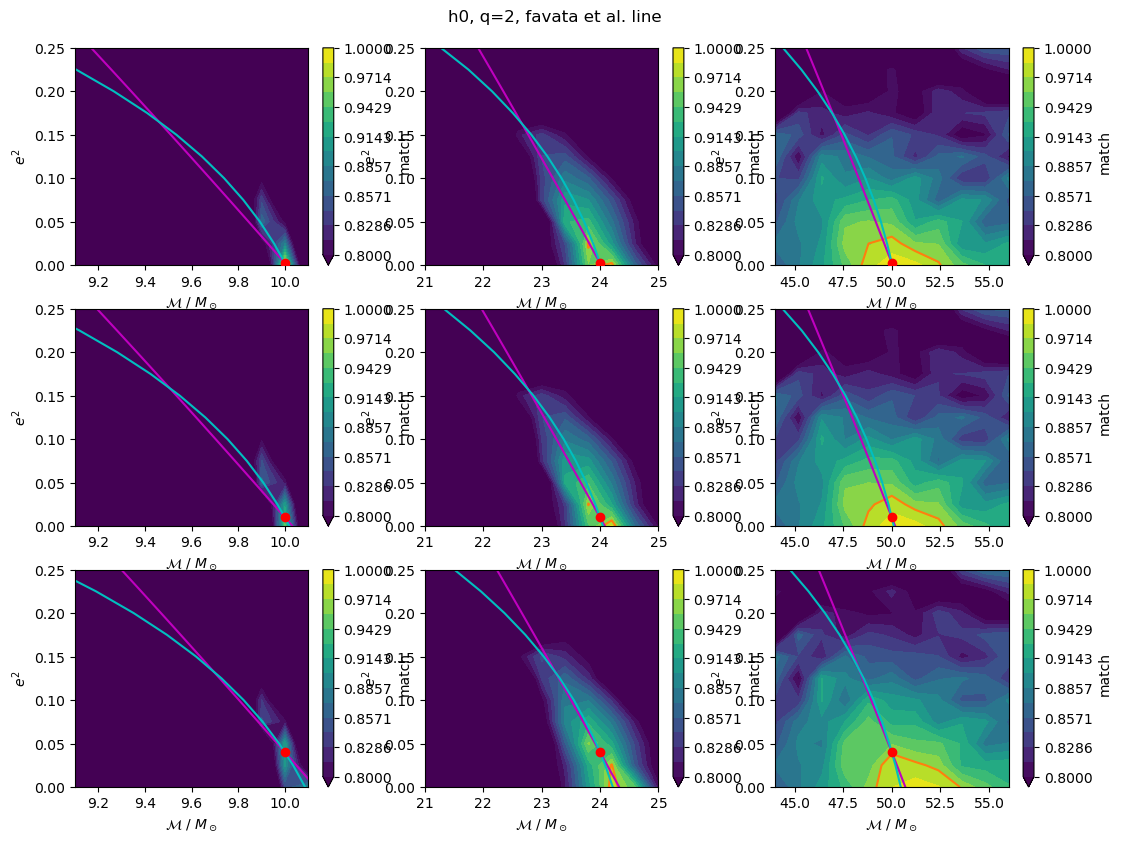

In [28]:
# Load data
with open(os.path.join('e_sqrd_chirp_data_v2', 'dataslot_0', 'all_matches'), 'rb') as fp:
        data = pickle.load(fp)

# Plot each with Favata et al. line
plt.figure(figsize=(6.4*2,4.8*2))
for i, fid_e in enumerate(data.keys()):
    for j, fid_chirp in enumerate(data[fid_e].keys()):
        plt.subplot(len(data.keys()), len(data[fid_e].keys()), i*len(data.keys())+j+1)
        plt.contourf(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['h0'], np.linspace(0.8, 1, 15), vmin=0.8, vmax=1, extend='min')
        plt.colorbar(label='match')
        plt.scatter(fid_chirp, fid_e**2, c='r', zorder=5)
        plt.contour(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['h0'], [0.97], colors=['C1'])
        xlims = plt.gca().get_xlim()
        ylims = plt.gca().get_ylim()
        plt.plot(favata_et_al_avg(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='m', label='old')
        plt.plot(favata_et_al_exact(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='c', label='new')
        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
plt.suptitle('h0, q=2, favata et al. line', x=0.5, y=0.92)

Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785
Average frequency: 41.98240505088887 Hz
Given_e shifted from 0.05 to 0.011045142229937575
Average frequency: 31.81227080237802 Hz
Given_e shifted from 0.05 to 0.014738504129398157
Average frequency: 40.845377636723185 Hz
Given_e shifted from 0.05 to 0.011369789127265531
Average frequency: 31.640605936873396 Hz
Given_e shifted from 0.05 to 0.014822922402520653
Average frequency: 41.08406755467665 Hz
Given_e shifted from 0.05 to 0.011300106234388697


/tmp/ipykernel_387065/1257731242.py:13: UserWarning: No contour levels were found within the data range.
  plt.contour(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['quad'], [0.97], colors=['C1'])


Average frequency: 32.551889993739294 Hz
Given_e shifted from 0.1 to 0.028770495046402916
Average frequency: 42.00100567484518 Hz
Given_e shifted from 0.1 to 0.022369864958391647
Average frequency: 31.82990373939218 Hz
Given_e shifted from 0.1 to 0.029459771835711808
Average frequency: 40.84332904702708 Hz
Given_e shifted from 0.1 to 0.023038392966233372
Average frequency: 31.536591988918705 Hz
Given_e shifted from 0.1 to 0.02974906424385393
Average frequency: 40.82251788628651 Hz
Given_e shifted from 0.1 to 0.023050766561709617
Average frequency: 32.832227521963944 Hz
Given_e shifted from 0.2 to 0.057022505302435716
Average frequency: 42.27653046113267 Hz
Given_e shifted from 0.2 to 0.04683720069070967
Average frequency: 32.09223665325241 Hz
Given_e shifted from 0.2 to 0.05841127377483943
Average frequency: 41.11518355880905 Hz
Given_e shifted from 0.2 to 0.04822315907724004
Average frequency: 31.793526572313365 Hz
Given_e shifted from 0.2 to 0.058990705064272564
Average frequency: 40

Text(0.5, 0.92, 'quad, q=2, favata et al. line')

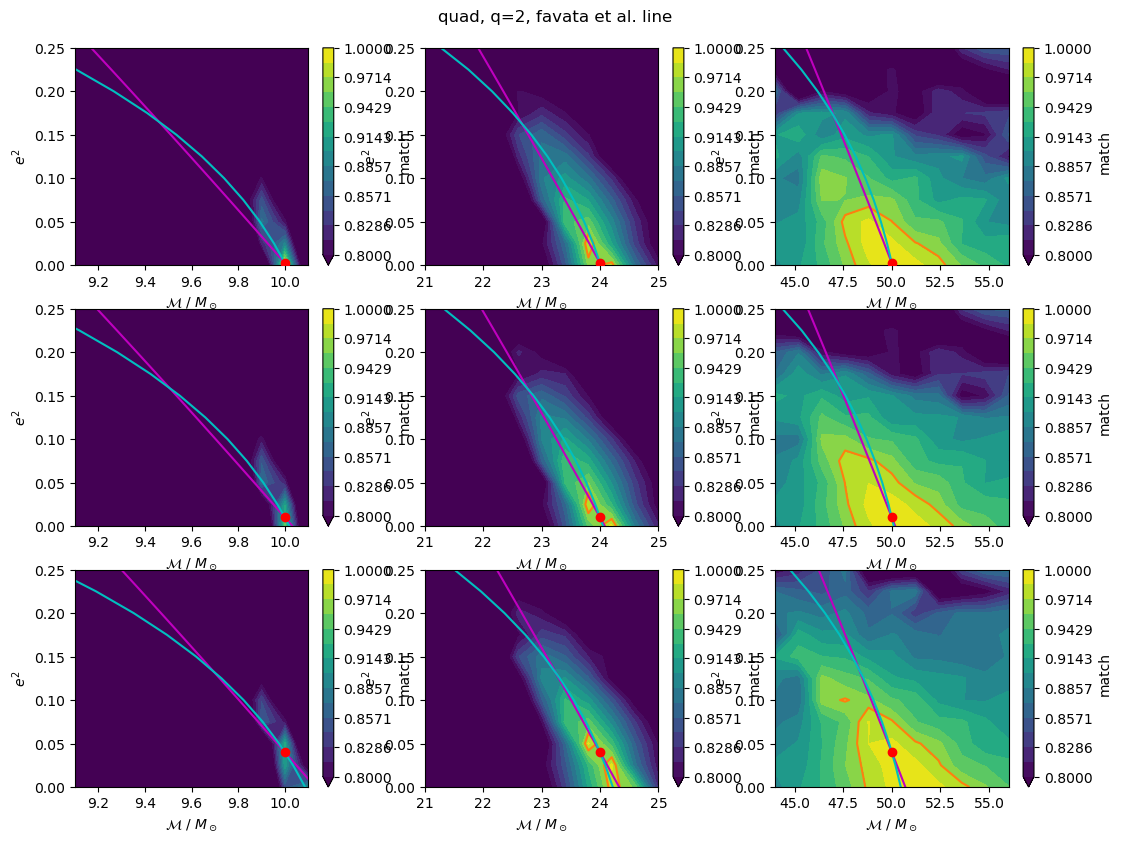

In [30]:
# Load data
with open(os.path.join('e_sqrd_chirp_data_v2', 'dataslot_0', 'all_matches'), 'rb') as fp:
        data = pickle.load(fp)

# Plot each with Favata et al. line
plt.figure(figsize=(6.4*2,4.8*2))
for i, fid_e in enumerate(data.keys()):
    for j, fid_chirp in enumerate(data[fid_e].keys()):
        plt.subplot(len(data.keys()), len(data[fid_e].keys()), i*len(data.keys())+j+1)
        plt.contourf(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['quad'], np.linspace(0.8, 1, 15), vmin=0.8, vmax=1, extend='min')
        plt.colorbar(label='match')
        plt.scatter(fid_chirp, fid_e**2, c='r', zorder=5)
        plt.contour(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['quad'], [0.97], colors=['C1'])
        xlims = plt.gca().get_xlim()
        ylims = plt.gca().get_ylim()
        plt.plot(favata_et_al_avg(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='m', label='old')
        plt.plot(favata_et_al_exact(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='c', label='new')
        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
plt.suptitle('quad, q=2, favata et al. line', x=0.5, y=0.92)

Average frequency: 32.516248909453864 Hz
Given_e shifted from 0.05 to 0.014401891692386785
Average frequency: 41.98240505088887 Hz
Given_e shifted from 0.05 to 0.011045142229937575
Average frequency: 31.81227080237802 Hz
Given_e shifted from 0.05 to 0.014738504129398157
Average frequency: 40.845377636723185 Hz
Given_e shifted from 0.05 to 0.011369789127265531
Average frequency: 31.640605936873396 Hz
Given_e shifted from 0.05 to 0.014822922402520653
Average frequency: 41.08406755467665 Hz
Given_e shifted from 0.05 to 0.011300106234388697


/tmp/ipykernel_387065/4105330728.py:13: UserWarning: No contour levels were found within the data range.
  plt.contour(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['quad'], [0.97], colors=['C1'])


Average frequency: 32.551889993739294 Hz
Given_e shifted from 0.1 to 0.028770495046402916
Average frequency: 42.00100567484518 Hz
Given_e shifted from 0.1 to 0.022369864958391647
Average frequency: 31.82990373939218 Hz
Given_e shifted from 0.1 to 0.029459771835711808
Average frequency: 40.84332904702708 Hz
Given_e shifted from 0.1 to 0.023038392966233372
Average frequency: 31.536591988918705 Hz
Given_e shifted from 0.1 to 0.02974906424385393
Average frequency: 40.82251788628651 Hz
Given_e shifted from 0.1 to 0.023050766561709617
Average frequency: 32.832227521963944 Hz
Given_e shifted from 0.2 to 0.057022505302435716
Average frequency: 42.27653046113267 Hz
Given_e shifted from 0.2 to 0.04683720069070967
Average frequency: 32.0922366532524 Hz
Given_e shifted from 0.2 to 0.058411273774839435
Average frequency: 41.11518355880905 Hz
Given_e shifted from 0.2 to 0.04822315907724004
Average frequency: 31.793526572313365 Hz
Given_e shifted from 0.2 to 0.058990705064272564
Average frequency: 40

Text(0.5, 0.92, 'h1/h0, q=2, favata et al. line')

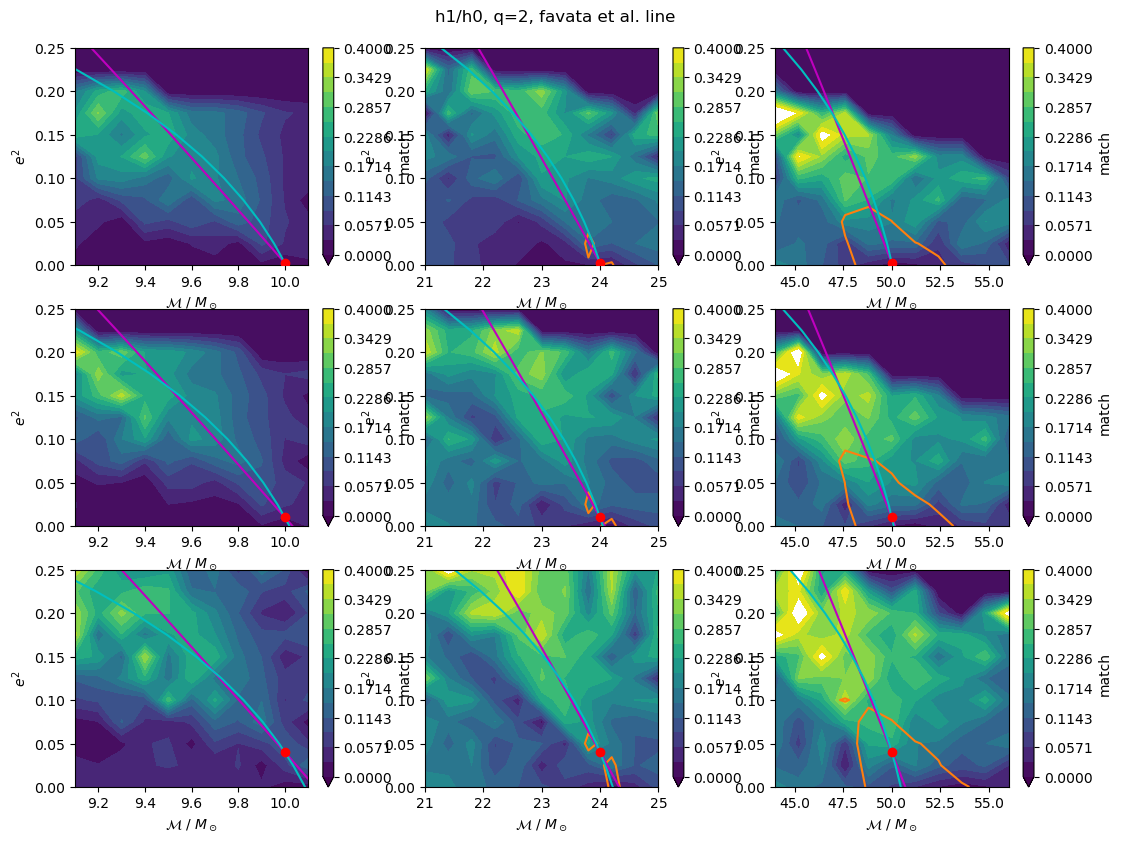

In [34]:
# Load data
with open(os.path.join('e_sqrd_chirp_data_v2', 'dataslot_0', 'all_matches'), 'rb') as fp:
        data = pickle.load(fp)

# Plot each with Favata et al. line
plt.figure(figsize=(6.4*2,4.8*2))
for i, fid_e in enumerate(data.keys()):
    for j, fid_chirp in enumerate(data[fid_e].keys()):
        plt.subplot(len(data.keys()), len(data[fid_e].keys()), i*len(data.keys())+j+1)
        plt.contourf(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['h1_h0'], np.linspace(0, 0.4, 15), vmin=0, vmax=0.4, extend='min')
        plt.colorbar(label='match')
        plt.scatter(fid_chirp, fid_e**2, c='r', zorder=5)
        plt.contour(data[fid_e][fid_chirp]['chirp_vals'], data[fid_e][fid_chirp]['e_vals']**2, data[fid_e][fid_chirp]['quad'], [0.97], colors=['C1'])
        xlims = plt.gca().get_xlim()
        ylims = plt.gca().get_ylim()
        plt.plot(favata_et_al_avg(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='m', label='old')
        plt.plot(favata_et_al_exact(fid_e, fid_chirp, data[fid_e][fid_chirp]['e_vals']), data[fid_e][fid_chirp]['e_vals']**2, c='c', label='new')
        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
plt.suptitle('h1/h0, q=2, favata et al. line', x=0.5, y=0.92)